# 基于“狗和牛角包”神经网络的狗狗品种分类

***

## 数据准备

我们在网上下载了120个种类的狗狗数据集


```
 Dog
    ├── infer
    │   ├── chihuahua.jpg
    │   └── Bloodhood.jpg
    ├── Images
    │   ├── 120种类狗的图片
```

In [6]:
import os

import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as transforms
import mindspore

mindspore.set_context(mode = mindspore.GRAPH_MODE, device_target = 'CPU')

In [3]:
#设置变量，遍历文件获取所有的分类名
path = './Images'
_, dirs, _ = next(os.walk(path))
dirs.sort()
class_num = 120

#保存遍历的文件名
with open('./Image_'+str(class_num)+'.txt', 'w') as f:
    f.write(str(dirs))

#### 数据集预处理


In [ ]:
def create_dataset(path, train=True, image_size=224, batch_size = 1):
    dataset = ds.ImageFolderDataset(path, num_parallel_workers=8, class_indexing={dirs[x]:x for x in range(class_num)})
    
    # 图像增强操作
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
    if train:

        trans = [
            transforms.RandomCropDecodeResize(image_size, scale=(0.08, 1.0), ratio=(0.75, 1.333)),
            transforms.RandomHorizontalFlip(prob=0.5),
            transforms.Normalize(mean=mean, std=std),
            transforms.HWC2CHW()
        ]
    else:
        trans = [
            transforms.Decode(),
            transforms.Resize(256),
            transforms.CenterCrop(image_size),
            transforms.Normalize(mean=mean, std=std),
            transforms.HWC2CHW()
        ]

    dataset = dataset.map(operations=trans, input_columns="image", num_parallel_workers=8)
    # 设置batch_size的大小，若最后一次抓取的样本数小于batch_size，则丢弃
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset.split([0.9,0.1])

# 加载训练数据集
dataset_train, dataset_val = create_dataset(path, train=True)

### MobileNet V2模型微调

使用MobileNet V2的预训练模型进行微调，通过删除MobileNet V2预训练模型中最后一个用于分类的1x1的卷积层的参数，使用**狗狗分类**数据集对模型进行重新训练。

In [ ]:
import mindspore.nn as nn
from mindspore.train import Model
from mindspore import load_checkpoint, load_param_into_net

from mindvision.classification.models import mobilenet_v2
from mindvision.engine.loss import CrossEntropySmooth

# 创建模型,其中目标分类数为2，图像输入大小为(224,224)
network = mobilenet_v2(num_classes=class_num, resize=224)

# 模型参数存入到param_dict
param_dict = load_checkpoint("./mobilenet_v2_1.0_224.ckpt")

# 获取mobilenet_v2网络最后一个卷积层的参数名
filter_list = [x.name for x in network.head.classifier.get_parameters()]

# 删除预训练模型的最后一个卷积层
def filter_ckpt_parameter(origin_dict, param_filter):
    for key in list(origin_dict.keys()):
        for name in param_filter:
            if name in key:
                print("Delete parameter from checkpoint: ", key)
                del origin_dict[key]
                break

filter_ckpt_parameter(param_dict, filter_list)

# 加载预训练模型参数作为网络初始化权重
load_param_into_net(network, param_dict)

# 定义优化器
network_opt = nn.Momentum(params=network.trainable_params(), learning_rate=0.01, momentum=0.9)

# 定义损失函数
network_loss = CrossEntropySmooth(sparse=True, reduction="mean", smooth_factor=0.1, classes_num=class_num)

# 定义评价指标
metrics = {"Accuracy": nn.Accuracy()}

# 初始化模型
model = Model(network, loss_fn=network_loss, optimizer=network_opt, metrics=metrics)

from mindvision.engine.callback import ValAccMonitor
from mindspore.train.callback import TimeMonitor

num_epochs = 10

# 模型训练与验证，训练完成后保存验证精度最高的ckpt文件（best.ckpt）到当前目录下
model.train(num_epochs,
            dataset_train,
            callbacks=[ValAccMonitor(model, dataset_val, num_epochs), TimeMonitor()])

### 可视化模型预测

定义 `visualize_model` 函数，使用上述验证精度最高的模型对输入图像进行预测，并将预测结果可视化

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import re
from PIL import Image

import mindspore.nn as nn
from mindspore.train import Model
from mindspore import load_checkpoint, load_param_into_net

from mindvision.classification.models import mobilenet_v2
from mindvision.engine.loss import CrossEntropySmooth

from mindspore import Tensor
from mindspore import ops
import os

with open('./Image_50.txt', 'r') as f:
    dirs = list(f.read()[1:-1].replace('\'','').split(','))

def visualize_model(path):
    image = Image.open(path).convert("RGB")
    image = image.resize((224, 224))
    plt.imshow(image)

    # 归一化处理
    mean = np.array([0.485 * 255, 0.456 * 255, 0.406 * 255])
    std = np.array([0.229 * 255, 0.224 * 255, 0.225 * 255])
    image = np.array(image)
    image = (image - mean) / std
    image = image.astype(np.float32)

    # 图像通道由(h, w, c)转换为(c, h, w)
    image = np.transpose(image, (2, 0, 1))

    # 扩展数据维数为(1, c, h, w)
    image = np.expand_dims(image, axis=0)

    # 定义并加载网络
    net = mobilenet_v2(num_classes=class_num, resize=224)
    param_dict = load_checkpoint("./best_120.ckpt")
    load_param_into_net(net, param_dict)
    model = Model(net)

    # 模型预测
    pre = model.predict(Tensor(image))
    result = np.argmax(pre)
    
    print(pre)
    print(result)
    softmax=ops.Softmax(-1)
    print(softmax(pre))
   
    class_name = {x:re.search('-.*', dirs[x]).group()[1:] for x in range(class_num)}
    plt.title(f"Predict: {class_name[result]}")
    return result

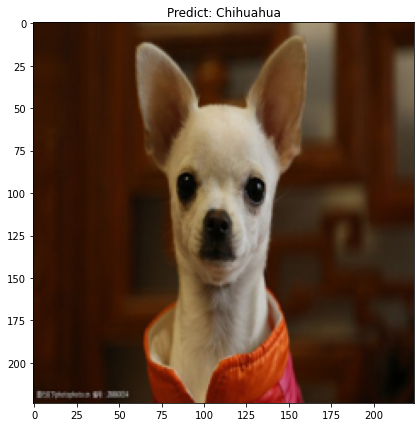

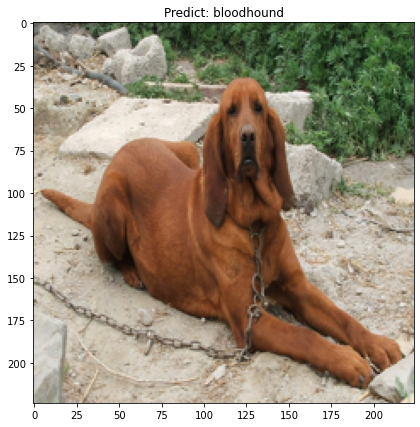

In [10]:
image1 = "./infer/chihuahua.jpg"
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
visualize_model(image1)


image2 = "./infer/Bloodhound.jpg"
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 2)
visualize_model(image2)

plt.show()